In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom

In [2]:
import os

## Image data is put in folder 'rsna-pneumonia-detection-challenge'

In [3]:
dir_dicom = os.path.join(os.getcwd(), 'rsna-pneumonia-detection-challenge')
os.listdir(dir_dicom)
!ls rsna-pneumonia-detection-challenge

import pandas

GCP Credits Request Link - RSNA.txt stage_2_test_images
stage_2_detailed_class_info.csv     stage_2_train_images
stage_2_sample_submission.csv       stage_2_train_labels.csv


In [4]:
df = pandas.read_csv(os.path.join(dir_dicom, 'stage_2_train_labels.csv'))

In [5]:
df = df.fillna(0)

Patients got diagnosed with numbers of bounding boxs, ranged from 0 to 4

In [6]:
df.groupby("patientId").size().reset_index(name="box_count").groupby("box_count").size()

box_count
1    23286
2     3266
3      119
4       13
dtype: int64

Therefore, do a tranpose and an aggregation

In [7]:
columns = ['x', 'y', 'width', 'height']
df['bounding_boxs'] = df[columns].to_dict(orient='record')
df = df.drop(columns=columns)
df

,patientId,Target,bounding_boxs
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}"
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}"
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}"
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}"
4,00436515-870c-4b36-a041-de91049b9ab4,1,"{'x': 264.0, 'y': 152.0, 'width': 213.0, 'heig..."
...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,1,"{'x': 185.0, 'y': 298.0, 'width': 228.0, 'heig..."
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}"
30224,c1f6b555-2eb1-4231-98f6-50a963976431,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}"
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,1,"{'x': 570.0, 'y': 393.0, 'width': 261.0, 'heig..."


In [8]:
df = df.groupby(["patientId", "Target"])["bounding_boxs"].apply(lambda df: df.reset_index(drop=True)).unstack().reset_index()

In [9]:
df

,patientId,Target,0,1,2,3
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN
1,000924cf-0f8d-42bd-9158-1af53881a557,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN
2,000db696-cf54-4385-b10b-6b16fbb3f985,1,"{'x': 316.0, 'y': 318.0, 'width': 170.0, 'heig...","{'x': 660.0, 'y': 375.0, 'width': 146.0, 'heig...",NaN,NaN
3,000fe35a-2649-43d4-b027-e67796d412e0,1,"{'x': 570.0, 'y': 282.0, 'width': 269.0, 'heig...","{'x': 83.0, 'y': 227.0, 'width': 296.0, 'heigh...",NaN,NaN
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1,"{'x': 66.0, 'y': 160.0, 'width': 373.0, 'heigh...","{'x': 552.0, 'y': 164.0, 'width': 376.0, 'heig...",NaN,NaN
...,...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,1,"{'x': 177.0, 'y': 285.0, 'width': 225.0, 'heig...","{'x': 641.0, 'y': 473.0, 'width': 201.0, 'heig...",NaN,NaN
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN
26681,fffc95b5-605b-4226-80ab-62caec682b22,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN
26682,fffcff11-d018-4414-971a-a7cefa327795,0,"{'x': 0.0, 'y': 0.0, 'width': 0.0, 'height': 0.0}",NaN,NaN,NaN


In [10]:
import matplotlib.patches as patches
dicoms_training = os.path.join(dir_dicom, 'stage_2_train_images')

In [11]:
def print_bounding_box(dicom):
    """plot rectangle boxs for a single dicom image
    params: patientId and bounding boxs       
    """
    _dicom_img = pydicom.dcmread(os.path.join(dicoms_training, dicom.patientId + '.dcm'))
    print("Patient id.......:", dicom.patientId)
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(_dicom_img.pixel_array, cmap=plt.cm.bone)#cmap stands for color map

    for bb in dicom[-4:]:
        if isinstance(bb, dict) and bb["x"] != "nan":
            x = bb["x"]
            y = bb["y"]
            w = bb["width"]
            h = bb["height"] 
            # Create a Rectangle patch
            rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)

    plt.show()

In [12]:
def print_samples(df, nc = 1):
    count = 0
    for index, row in df.iterrows():
        print_bounding_box(row)
        count +=1
        
        if count >= nc:
            break

## Get some samples of bb(bounding boxs) of 1, 2, 3, 4

In [13]:
df_4 = df[df[3].notna()]
df_3 = df[df[2].notna()]
df_2 = df[df[1].notna()]
df_1 = df[df[0].notna()]
df_0 = df[df[0] == dict(x=0, y=0, width=0, height=0)]

df_3 = df_3[~df_3.patientId.isin(df_4.patientId)]
df_2 = df_2[~df_2.patientId.isin(df_3.patientId)]
df_1 = df_1[~df_1.patientId.isin(df_2.patientId)]
df_1 = df_1[~df_1.patientId.isin(df_0.patientId)]

Patient id.......: 0ab261f9-4eb5-42ab-a9a5-e918904d6356


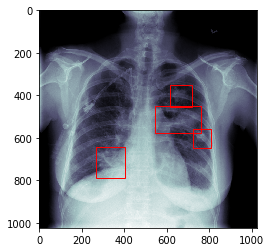

In [14]:
print_samples(df_4)

Patient id.......: 02b7b018-0fed-44c2-a9c2-93b2b3952efc


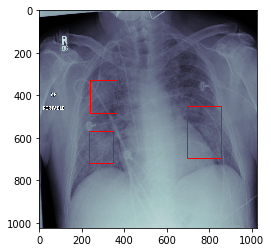

In [15]:
print_samples(df_3)

Patient id.......: 000db696-cf54-4385-b10b-6b16fbb3f985


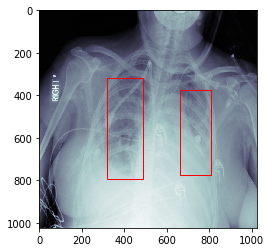

In [16]:
print_samples(df_2)

Patient id.......: 001916b8-3d30-4935-a5d1-8eaddb1646cd


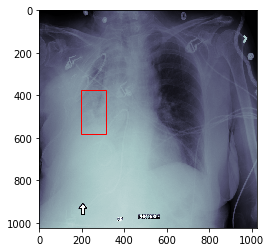

In [17]:
print_samples(df_1)